In [39]:
#modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set()

In [40]:
#import data and make a copy
raw_data = pd.read_csv('Index2018.csv')
data = raw_data.copy()

#transform data to time series
data.date = pd.to_datetime(data.date, dayfirst=True)
data.set_index('date', inplace=True)
data = data.asfreq('b')
data = data.fillna(method = 'ffill')

#We are working with FTSE so we isolate that
data['market_value'] = data.ftse
del data['spx'], data['dax'], data['ftse'], data['nikkei']
data['returns'] = data.market_value.pct_change(1).mul(100)
data = data.iloc[1:]

### Normalizing Values
To be able to compare different prices with each other, we need to normalize each distribution. Prices are of different magnitudes so to be able to compare them, you need to set a benchmark by which to compare each value and standardize the whole series using that value. For example change of 100 on the nikkei is not the same as change of 100 on ftse because that is a different percentage change for each. We continue working with the FTSE to standardize the ***market price i.e. market_value***

In [41]:
#set benchmark (initial value) and divide all by it
benchmark = data.market_value.iloc[0]
data['norm'] = data.market_value.div(benchmark).mul(100)

In [42]:
#adf test to make sure norm is stationary
sts.adfuller(data.norm)

(-1.5870996932040826,
 0.4900704664018051,
 6,
 6269,
 {'1%': -3.4313935443677157,
  '5%': -2.8620011543157835,
  '10%': -2.5670154694652805},
 24302.76353860927)

p-value > 0.05 => there is a unit root => series did not come from a stationary process =>not useful for predicting normalized values with AR models without further transformation.   
**Normalizing does not affect stationarity** You will see that returns stay stationary when normalized below.

We can normalize the returns!

In [43]:
ret_bm = data.returns.iloc[0]
data['ret_norm'] = data.returns.div(ret_bm).mul(100)
sts.adfuller(data.ret_norm)

(-15.140761332034925,
 7.01633845109149e-28,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 99642.30855107102)

p-value <<< 0.05 so series is stationary and has useful extractable information in predicting returns that can be compared across prices.

**Model Fit for Normalized Returns**
Normalizing the returns also does not change the optimal AR model selected regardless of the data set. We can proceed with our previously optimal model for returns which was an AR(6) models and review/interpret residuals of the model.

In [44]:
#Split into train(model) and test(forecasting) sets (80/20)
size = int(len(data)*0.8)
train = data.iloc[:size]
test = data.iloc[size:]

#remove normalized prices
del data['norm'], train['norm'], test['norm']

In [45]:
#AR 6 Model was best for returns so we use it here
model_ret_ar6 = ARMA(train.returns, order=(6,0))
results_ret_ar6 = model_ret_ar6.fit()

#add residuals to the series
train['res_returns'] = results_ret_ar6.resid

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
train.head()

,market_value,returns,ret_norm,res_returns
date,,,,
1994-01-10,3440.58,-0.156704,100.000000,-0.175623
1994-01-11,3413.77,-0.779229,497.260711,-0.802198
1994-01-12,3372.02,-1.222988,780.443046,-1.270028
1994-01-13,3360.01,-0.356166,227.285567,-0.466065
1994-01-14,3400.56,1.206842,-770.139292,1.061277


Reviewing mean and variance of error   
**Objective:** Mean should be close to 0 to indicate normal distribution and variance should be low to indicate that most values are concentrated around the mean (heteroskedasticity)
- We will review this manually and also run the ADF test to make sure the residual series is stationary

In [48]:
#mean and variance calculations
print('Residuals mean:', train.res_returns.mean(), '\nResiduals variance:', train.res_returns.var())

Residuals mean: -5.3753378245963446e-05 
Residuals variance: 1.3559802110694925


In [49]:
sts.adfuller(train.res_returns)

(-70.78379951416683,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.570834279846)

The mean is close to zero, the variance is small, and the p-value from the ADF test indicate no unit roots meaning the residuals are a stationary series. See the ACF and PACF figures below

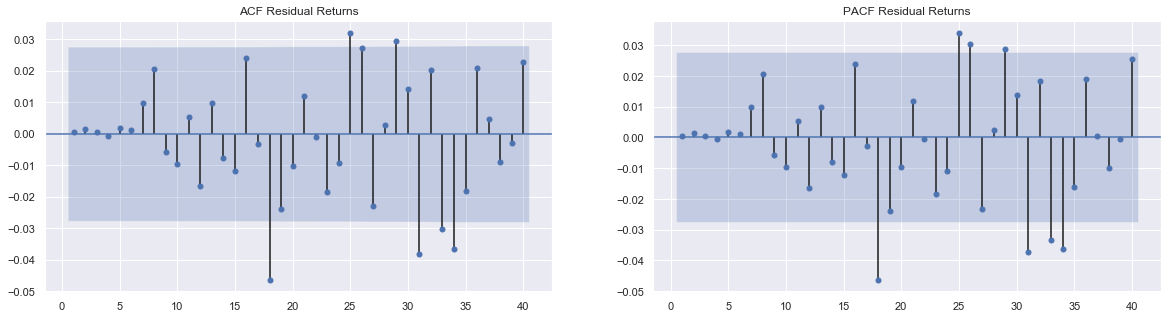

In [53]:
#ACF and PACF
def ACF_and_PACF(series, name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
    sgt.plot_acf(series, lags = 40, zero=False,ax=ax1)
    sgt.plot_pacf(series, lags = 40, zero = False, method='ols',ax=ax2)
    ax1.title.set_text('ACF ' + name)
    ax2.title.set_text('PACF ' + name)
    plt.show()
    
ACF_and_PACF(train.res_returns, 'Residual Returns')

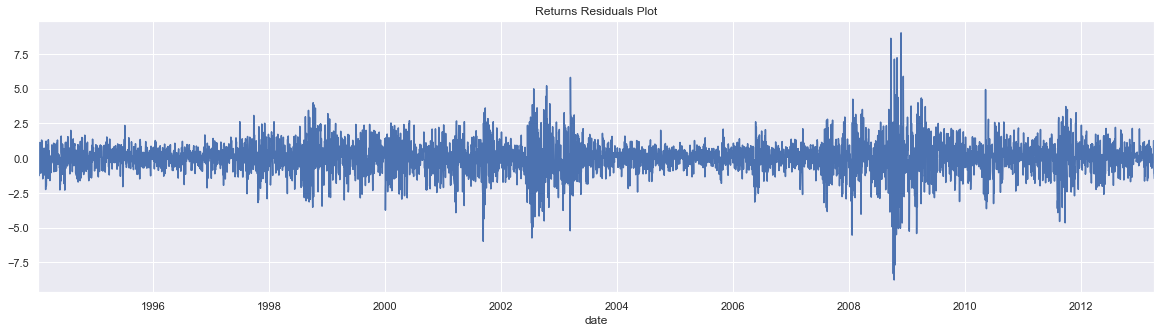

In [54]:
train.res_returns.plot(figsize=(20,5))
plt.title('Returns Residuals Plot')
plt.show()

Residuals have shocks in the early 2000 (dot com bubble) and 2009 (great recession). These shocks need to be accounted for... Either as outliers (if they are the only one), regime switches (if a rule trend follows depending on direction of effect), or moving average (MA) models as well. MA models are only part of the solution!!